In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, classification_report
from sklearn import model_selection


In [2]:
rooth_path = '../rawdata/outro/'
generator_df = pd.read_csv(rooth_path + 'generator_df.csv')
gen_bear_df = pd.read_csv(rooth_path + 'gen_bear_df.csv')
hyd_df = pd.read_csv(rooth_path + 'hyd_df.csv')
gearbox_df = pd.read_csv(rooth_path + 'gearbox_df.csv')
transf_df = pd.read_csv(rooth_path + 'transf_df.csv')

In [3]:
generator_df['Timestamp'] = pd.to_datetime(generator_df['Timestamp'])
gen_bear_df['Timestamp'] = pd.to_datetime(gen_bear_df['Timestamp'])
hyd_df['Timestamp'] = pd.to_datetime(hyd_df['Timestamp'])
gearbox_df['Timestamp'] = pd.to_datetime(gearbox_df['Timestamp'])
transf_df['Timestamp'] = pd.to_datetime(transf_df['Timestamp'])

In [4]:
#By Pearson corr analysis
features_drop = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg','Gen_Phase3_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
                'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min','Grd_Prod_VoltPhse2_Avg',
                'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min', 'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg',
                'Spin_Temp_Avg', 'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg', 'Grd_Prod_CurPhse1_Avg', 'Prod_LatestAvg_TotActPwr',
                 'Grd_Prod_CurPhse3_Avg', 'Grd_Prod_Pwr_Max', 'Grd_Prod_Pwr_Min', 'HVTrafo_Phase1_Temp_Avg', 'Grd_Prod_CurPhse2_Avg',
                 'HVTrafo_Phase3_Temp_Avg', 'Grd_Prod_PsblePwr_Max', 'Grd_Prod_PsblePwr_Min', 'Grd_Prod_ReactPwr_Avg',
                'Grd_Prod_PsbleInd_Max', 'Grd_Prod_PsbleInd_Min', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotReactPwr',
                'Grd_Prod_PsbleInd_Avg', 'Blds_PitchAngle_Avg', 'Grd_Prod_ReactPwr_Max', 'Grd_Prod_ReactPwr_Min',
                'Nac_Direction_Avg', 'Amb_WindDir_Abs_Avg', 'Grd_Prod_PsbleCap_Min', 'Gear_Oil_Temp_Avg', 'Grd_Prod_VoltPhse1_Avg']

In [5]:
## Remove columns with strong correlations
generator_df = generator_df.drop(columns=features_drop)
gen_bear_df = gen_bear_df.drop(columns=features_drop)
hyd_df = hyd_df.drop(columns=features_drop)
gearbox_df = gearbox_df.drop(columns=features_drop)
transf_df = transf_df.drop(columns=features_drop)

In [6]:
def prepare_train_test(df):
    last_date = df['Timestamp'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    df_train = df[df['Timestamp'] < split]
    df_test = df[df['Timestamp'] >= split]
    
    return df_train, df_test

In [7]:
generator_df_train, generator_df_test = prepare_train_test(generator_df)
gen_bear_df_train, gen_bear_df_test = prepare_train_test(gen_bear_df)
hyd_df_train, hyd_df_test = prepare_train_test(hyd_df)
gearbox_df_train, gearbox_df_test = prepare_train_test(gearbox_df)
transf_df_train, transf_df_test = prepare_train_test(transf_df)

In [8]:
#Group by day per turbine
def group_per_frequency(df, strategy='mean'):
    df['Date'] = df['Timestamp'].dt.date
    if strategy == 'max':
        df = df.groupby(by=['Turbine_ID','Date']).max().reset_index().drop(columns='Timestamp')
    else:
        df = df.groupby(by=['Turbine_ID','Date']).mean().reset_index()
        
    return df

In [9]:
df_train_gearbox_day = group_per_frequency(gearbox_df_train)
df_train_gen_day = group_per_frequency(generator_df_train)
df_train_gen_bear_day = group_per_frequency(gen_bear_df_train)
df_train_hyd_day = group_per_frequency(hyd_df_train)
df_train_transf_day = group_per_frequency(transf_df_train)
df_test_gearbox_day = group_per_frequency(gearbox_df_test)
df_test_gen_day = group_per_frequency(generator_df_test)
df_test_gen_bear_day = group_per_frequency(gen_bear_df_test)
df_test_hyd_day = group_per_frequency(hyd_df_test)
df_test_transf_day = group_per_frequency(transf_df_test)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
dfs = [df_train_gearbox_day,df_train_gen_day, df_train_gen_bear_day, df_train_hyd_day, df_train_transf_day,
       df_test_gearbox_day, df_test_gen_day, df_test_gen_bear_day, df_test_hyd_day, df_test_transf_day ]

for df in dfs:
    df['60_days'] = df['60_days'].round(decimals=0)
    df['50_days'] = df['50_days'].round(decimals=0)
    df['40_days'] = df['40_days'].round(decimals=0)
    df['30_days'] = df['30_days'].round(decimals=0)
    df['20_days'] = df['20_days'].round(decimals=0)
    df['10_days'] = df['10_days'].round(decimals=0)

In [11]:
def add_features(df_in, rolling_win_size):
    
    sensor_cols = []
    for i in df_in.keys()[2:-8]:
        sensor_cols.append(i)
    sensor_av_cols = [nm+'_av' for nm in sensor_cols]
    sensor_sd_cols = [nm+'_sd' for nm in sensor_cols]
    df_out = pd.DataFrame()
    ws = rolling_win_size
    #calculate rolling stats for each engine id
    for m_id in pd.unique(df_in.Turbine_ID):
        # get a subset for each engine sensors
        df_engine = df_in[df_in['Turbine_ID'] == m_id]
        df_sub = df_engine[sensor_cols]
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
    return df_out

In [12]:
df_train_gearbox_extra = add_features(df_train_gearbox_day, 7)
df_train_gen_extra = add_features(df_train_gen_day, 7)
df_train_gen_bear_extra = add_features(df_train_gen_bear_day, 7)
df_train_hyd_extra = add_features(df_train_hyd_day, 7)
df_train_transf_extra = add_features(df_train_transf_day, 7)
df_test_gearbox_extra = add_features(df_test_gearbox_day, 7)
df_test_gen_extra = add_features(df_test_gen_day, 7)
df_test_gen_bear_extra = add_features(df_test_gen_bear_day, 7)
df_test_hyd_extra = add_features(df_test_hyd_day, 7)
df_test_transf_extra = add_features(df_test_transf_day, 7)

In [13]:
#Failures Generator in train data - T06 and T11
#Failures Hydraulic Group in train data - T06 and T11
#Failures Gen_bear in train data - T07 and T09
#Failures Transformer in train data - T07
# Gearbox -> Change train_test in order to be 1 failure in test data

In [14]:
df_train_gen = df_train_gen_extra.loc[(df_train_gen_extra['Turbine_ID']=='T06') | (df_train_gen_extra['Turbine_ID']=='T11')]
df_train_gen_bear = df_train_gen_bear_extra.loc[(df_train_gen_bear_extra['Turbine_ID']=='T07') | (df_train_gen_bear_extra['Turbine_ID']=='T09')]
df_train_hyd = df_train_hyd_extra.loc[(df_train_hyd_extra['Turbine_ID']=='T06') | (df_train_hyd_extra['Turbine_ID']=='T11')]
df_train_transf = df_train_transf_extra.loc[df_train_transf_extra['Turbine_ID']=='T07']
df_test_gen = df_test_gen_extra.copy()
df_test_gen_bear = df_test_gen_bear_extra.copy()
df_test_hyd = df_test_hyd_extra.copy()
df_test_transf = df_test_transf_extra.copy()

In [15]:
#Scaling
def scale(df_train, df_test, scaler='StandardScaler'):
    
    for m_id in pd.unique(df_train.Turbine_ID):
        X_train = df_train.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']) 
        X_test = df_test.drop(columns=['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID'])
        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_scale = sc.fit_transform(X_train)
            X_test_scale = sc.transform(X_test)
        else:
            sc = StandardScaler()
            X_train_scale = sc.fit_transform(X_train)
            X_test_scale = sc.transform(X_test)

        
    return X_train_scale, X_test_scale

In [16]:
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
     
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    train_pred = grid_search.predict(X_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [17]:
def metrics(estimator, X_test, y_test, y_pred, label):
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    plot_roc_curve(estimator, X_test, y_test, name = f'{estimator} {label}')

In [18]:
def logreg(X_train, X_test, y_train, y_test, label):
    model = 'Logistic Regression'
    clf_logreg = LogisticRegression(random_state=42, max_iter=3000, n_jobs=-1)
    gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
    gs_score = 'f1'

    clf_logreg, pred_logreg = bin_classify(model, clf_logreg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_logreg)
    
    metrics(clf_logreg, X_test, y_test, pred_logreg['y_pred'], label)
    
    return clf_logreg, pred_logreg

In [19]:
def rfc(X_train, X_test, y_train, y_test, label):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [800, 900, 1000, 1300, 1400, 1500], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None]}
    gs_score = 'f1'

    clf_rfc, pred_rfc = bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)
    
    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'], label)
    
    return clf_rfc, pred_rfc

In [20]:
def gbc(X_train, X_test, y_train, y_test, label):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1], 'n_estimators': [100, 200, 500, 700]}
    gs_score = 'f1'

    clf_gbc, pred_gbc= bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'], label)
    
    return clf_gbc, pred_gbc

In [21]:
def knn(X_train, X_test, y_train, y_test, label):
    model = 'KNN'
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    gs_params = {'n_neighbors': [5, 7, 10, 15]}
    gs_score = 'f1'

    clf_knn, pred_knn= bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'], label)
    
    return clf_knn, pred_knn

In [22]:
def abc(X_train, X_test, y_train, y_test, label):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [50, 100, 200, 300, 500]}
    gs_score = 'f1'

    clf_abc, pred_abc= bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'], label)
    
    return clf_abc, pred_abc

In [23]:
def svc(X_train, X_test, y_train, y_test, label):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'class_weight': ['balanced', None], 'gamma': ['auto', 'scale']}
    gs_score = 'f1'

    clf_svc, pred_svc= bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'], label)
    
    return clf_svc, pred_svc

# GENERATOR

In [24]:
feat_drop = ['Date', 'TTF', '60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Component', 'Turbine_ID']
labels = ['60_days', '50_days', '40_days' ,'30_days', '20_days', '10_days']

Generator 60_days


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       406
         1.0       0.00      0.00      0.00        59

    accuracy                           0.83       465
   macro avg       0.43      0.48      0.45       465
weighted avg       0.76      0.83      0.79       465

[[388  18]
 [ 59   0]]

Best Parameters:
 RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.97      0.57      0.71       406
         1.0       0.22      0.86      0.36        59

    accuracy                           0.60       465
   macro avg       0.60      0.72      0.54       465
weighted avg       0.87      0.60      0.67       465

[[230 176]
 [  8  51]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=700, rand

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       416
         1.0       0.00      0.00      0.00        49

    accuracy                           0.79       465
   macro avg       0.44      0.44      0.44       465
weighted avg       0.79      0.79      0.79       465

[[366  50]
 [ 49   0]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=900, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82       416
         1.0       0.22      0.67      0.33        49

    accuracy                           0.72       465
   macro avg       0.59      0.70      0.58       465
weighted avg       0.87      0.72      0.77       465

[[300 116]
 [ 16  33]]

Best Parameters

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85       426
         1.0       0.20      0.62      0.30        39

    accuracy                           0.76       465
   macro avg       0.58      0.69      0.58       465
weighted avg       0.89      0.76      0.81       465

[[329  97]
 [ 15  24]]

Best Parameters:
 RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       1.00      0.54      0.70       426
         1.0       0.17      1.00      0.28        39

    accuracy                           0.58       465
   macro avg       0.58      0.77      0.49       465
weighted avg       0.93      0.58      0.66       465

[[229 197]
 [  0  39]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=0.01, n_estimators=700,


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73       436
         1.0       0.13      0.93      0.22        29

    accuracy                           0.60       465
   macro avg       0.56      0.75      0.48       465
weighted avg       0.94      0.60      0.70       465

[[251 185]
 [  2  27]]

Best Parameters:
 RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80       436
         1.0       0.17      1.00      0.28        29

    accuracy                           0.69       465
   macro avg       0.58      0.83      0.54       465
weighted avg       0.95      0.69      0.77       465

[[290 146]
 [  0  29]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, n_estimators=500, ra

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()



Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       436
         1.0       0.15      0.48      0.22        29

    accuracy                           0.79       465
   macro avg       0.55      0.65      0.55       465
weighted avg       0.91      0.79      0.84       465

[[354  82]
 [ 15  14]]

Best Parameters:
 AdaBoostClassifier(n_estimators=100, random_state=42)
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77       436
         1.0       0.15      1.00      0.26        29

    accuracy                           0.65       465
   macro avg       0.58      0.81      0.52       465
weighted avg       0.95      0.65      0.74       465

[[273 163]
 [  0  29]]

Best Parameters:
 SVC(C=1.2, class_weight='balanced', degree=2, kernel='poly', random_state=42)
              precision    recall  f1-score   support

         

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67       446
         1.0       0.08      1.00      0.15        19

    accuracy                           0.52       465
   macro avg       0.54      0.75      0.41       465
weighted avg       0.96      0.52      0.65       465

[[225 221]
 [  0  19]]

Best Parameters:
 RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       446
         1.0       0.10      0.05      0.07        19

    accuracy                           0.94       465
   macro avg       0.53      0.52      0.52       465
weighted avg       0.93      0.94      0.93       465

[[437   9]
 [ 18   1]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
      

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87       456
         1.0       0.08      1.00      0.15         9

    accuracy                           0.78       465
   macro avg       0.54      0.89      0.51       465
weighted avg       0.98      0.78      0.86       465

[[354 102]
 [  0   9]]

Best Parameters:
 RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.98       465
   macro avg       0.49      0.50      0.49       465
weighted avg       0.96      0.98      0.97       465

[[454   2]
 [  9   0]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
     

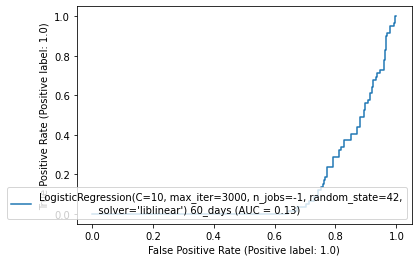

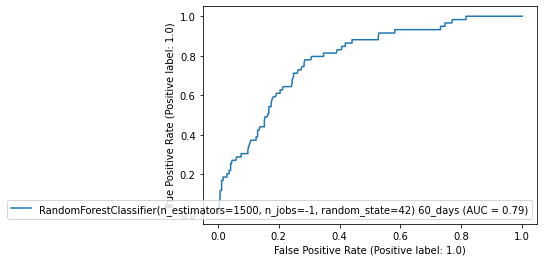

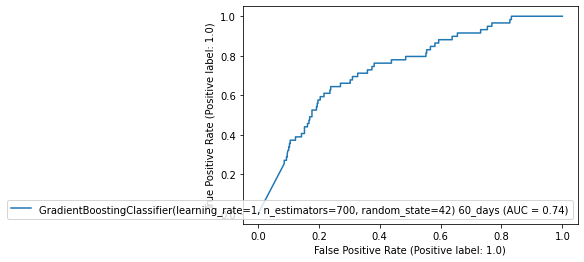

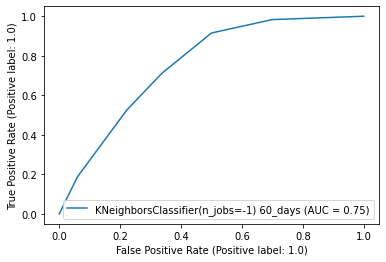

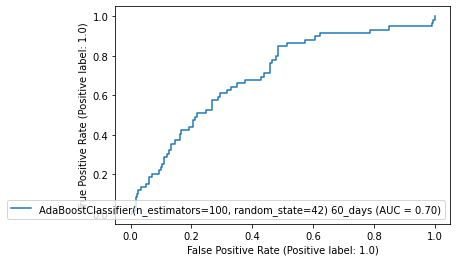

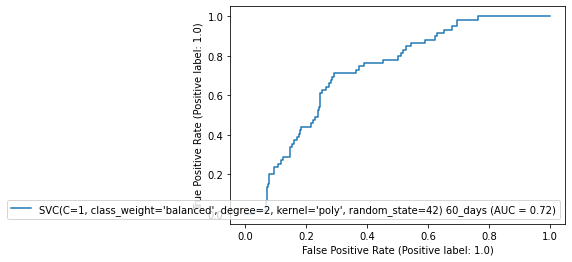

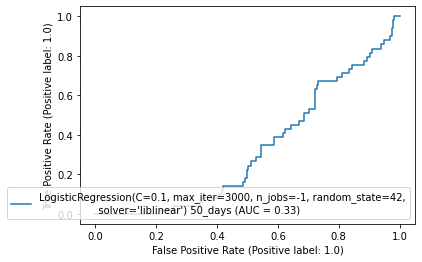

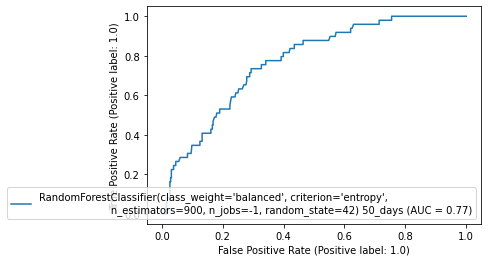

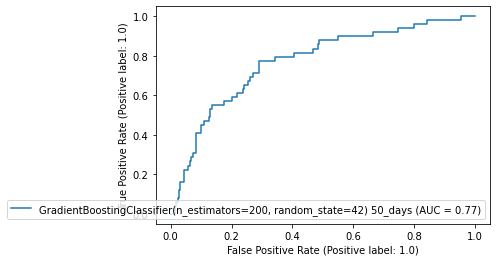

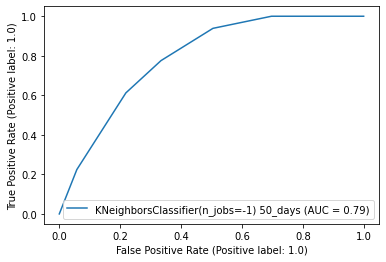

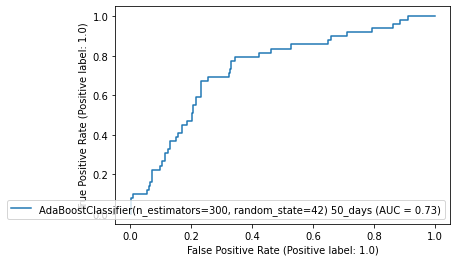

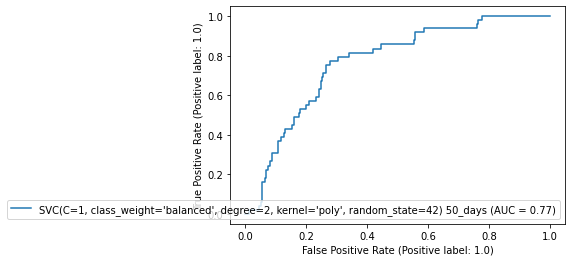

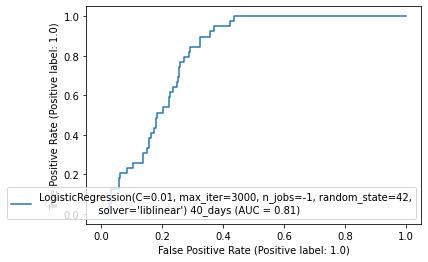

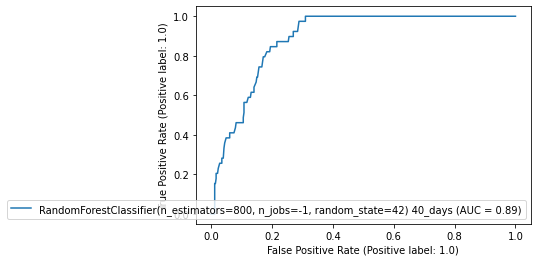

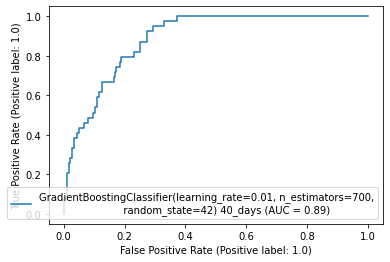

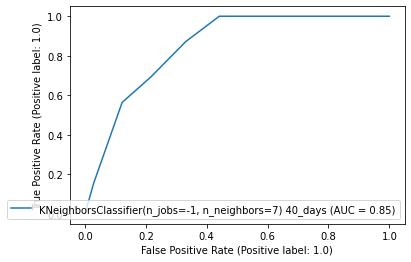

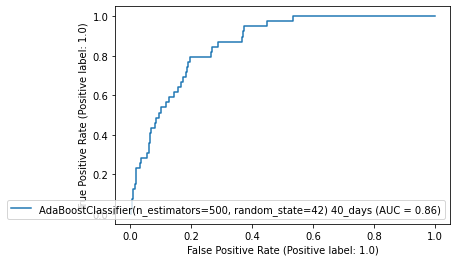

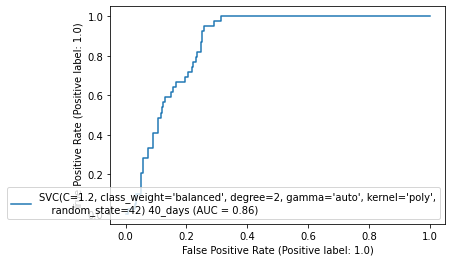

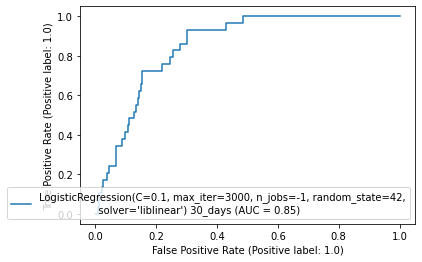

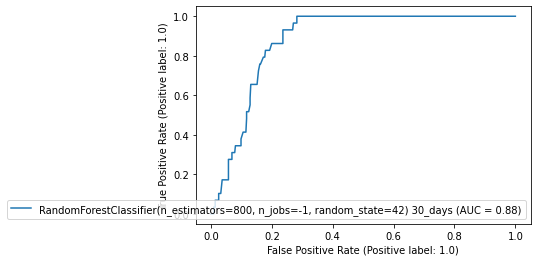

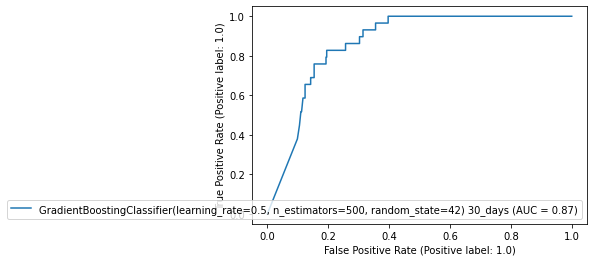

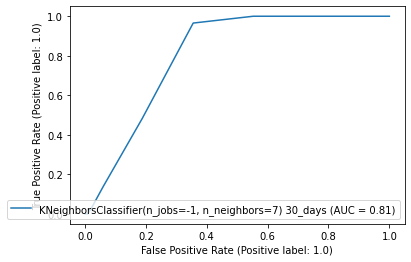

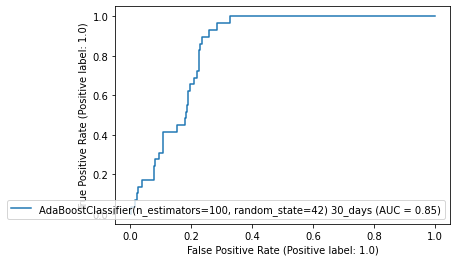

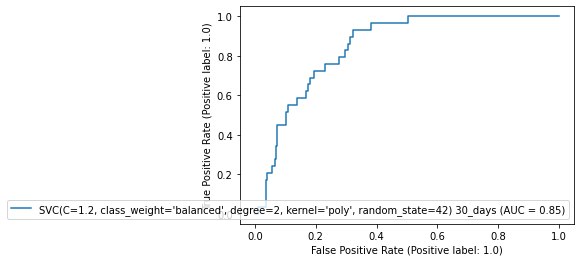

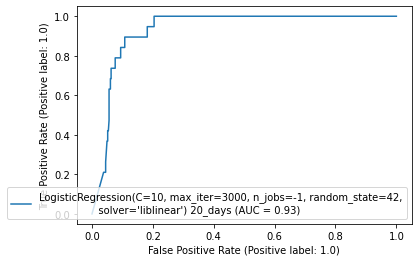

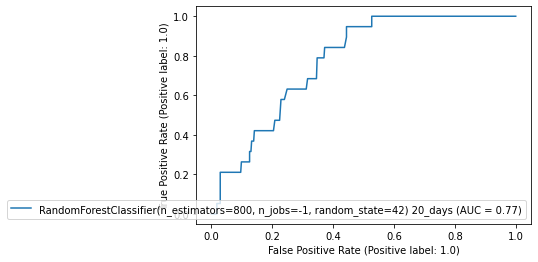

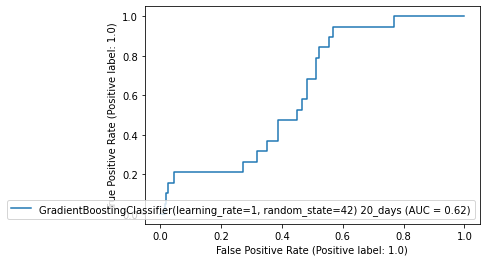

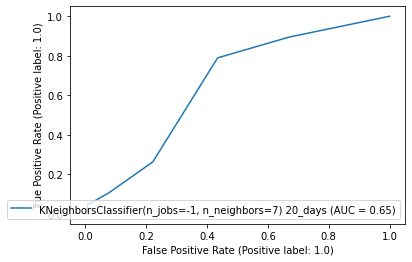

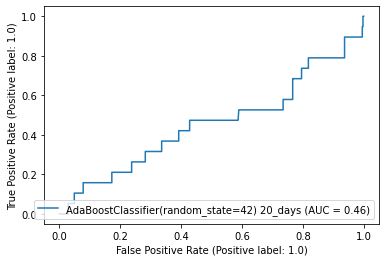

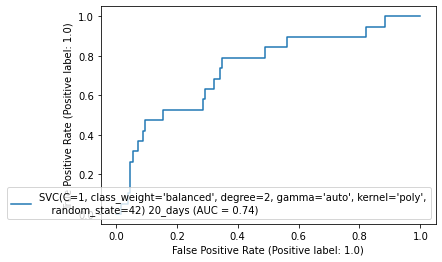

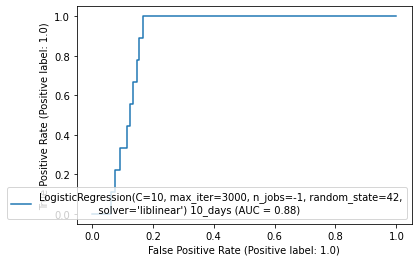

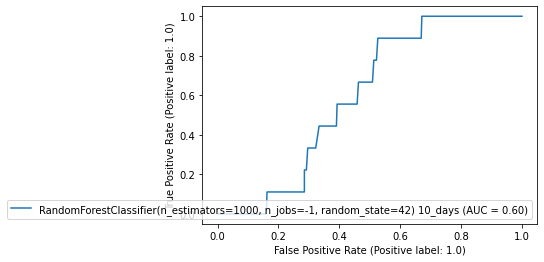

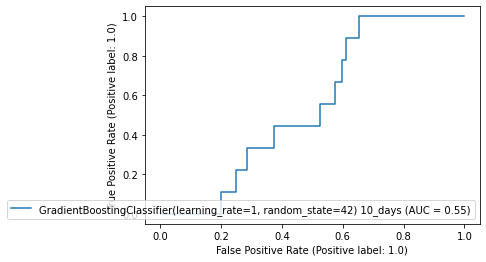

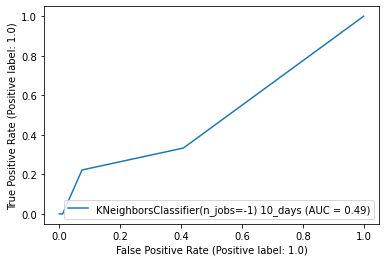

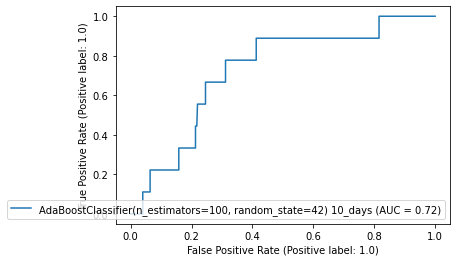

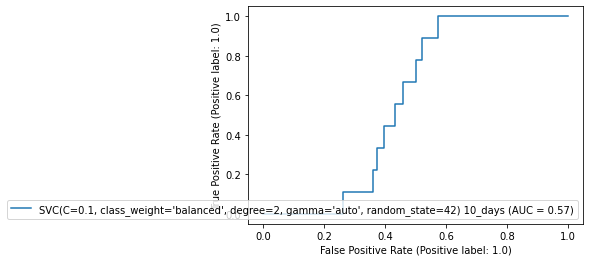

In [25]:
X_train_scale_gen, X_test_scale_gen = scale(df_train_gen, df_test_gen)
X_train_gen = df_train_gen.drop(columns=feat_drop)
X_test_gen = df_test_gen.drop(columns=feat_drop)
pred_logreg_gen = {}
pred_rfc_gen = {}
pred_gbc_gen = {}
pred_knn_gen = {}
pred_abc_gen = {}
pred_svc_gen = {}
for label in labels:
    y_train_gen = df_train_gen[label]
    y_test_gen = df_test_gen[label]
    print(f'Generator {label}')
    clf_logreg_gen, pred_logreg_gen[label] = logreg(X_train_gen, X_test_gen, y_train_gen, y_test_gen, label)
    clf_rfc_gen, pred_rfc_gen[label] = rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen, label)
    clf_gbc_gen, pred_gbc_gen[label] = gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen, label)
    clf_knn_gen, pred_knn_gen[label] = knn(X_train_scale_gen, X_test_scale_gen, y_train_gen, y_test_gen, label)
    clf_abc_gen, pred_abc_gen[label] = abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen, label)
    clf_svc_gen, pred_svc_gen[label] = svc(X_train_scale_gen, X_test_scale_gen, y_train_gen, y_test_gen, label)

# Hydraulic System

Hydraulic 60_days


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88       391
         1.0       0.00      0.00      0.00        74

    accuracy                           0.79       465
   macro avg       0.42      0.47      0.44       465
weighted avg       0.70      0.79      0.74       465

[[366  25]
 [ 74   0]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       391
         1.0       0.00      0.00      0.00        74

    accuracy                           0.84       465
   macro avg       0.42      0.50      0.46       465
weighted avg       0.71      0.84      0.77       465

[[391   0]
 [ 74   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       391
         1.0       0.12      0.05      0.07        74

    accuracy                           0.78       465
   macro avg       0.48      0.49      0.48       465
weighted avg       0.72      0.78      0.75       465

[[361  30]
 [ 70   4]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       391
         1.0       0.06      0.03      0.04        74

    accuracy                           0.78       465
   macro avg       0.45      0.48      0.46       465
weighted avg       0.71      0.78      0.74       465

[[362  29]
 [ 72   2]]

Best Parameters:
 AdaBoostClassifier(random_state=42)
              precision    recall  f1-score   support

         0.0       0.84      0.96      

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       401
         1.0       0.00      0.00      0.00        64

    accuracy                           0.85       465
   macro avg       0.43      0.50      0.46       465
weighted avg       0.74      0.85      0.79       465

[[397   4]
 [ 64   0]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=1500, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       401
         1.0       0.00      0.00      0.00        64

    accuracy                           0.86       465
   macro avg       0.43      0.50      0.46       465
weighted avg       0.74      0.86      0.80       465

[[401   0]
 [ 64   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       401
         1.0       0.05      0.05      0.05        64

    accuracy                           0.76       465
   macro avg       0.45      0.46      0.46       465
weighted avg       0.74      0.76      0.75       465

[[349  52]
 [ 61   3]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       401
         1.0       0.00      0.00      0.00        64

    accuracy                           0.82       465
   macro avg       0.43      0.47      0.45       465
weighted avg       0.74      0.82      0.77       465

[[379  22]
 [ 64   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=300, random_state=42)
              precision    recall  f1-score   support

         0.0       0.86

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       411
         1.0       0.02      0.04      0.02        54

    accuracy                           0.66       465
   macro avg       0.44      0.39      0.41       465
weighted avg       0.76      0.66      0.70       465

[[304 107]
 [ 52   2]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=1300, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       411
         1.0       0.00      0.00      0.00        54

    accuracy                           0.88       465
   macro avg       0.44      0.50      0.47       465
weighted avg       0.78      0.88      0.83       465

[[411   0]
 [ 54   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89       411
         1.0       0.02      0.02      0.02        54

    accuracy                           0.80       465
   macro avg       0.45      0.46      0.45       465
weighted avg       0.78      0.80      0.79       465

[[370  41]
 [ 53   1]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       411
         1.0       0.00      0.00      0.00        54

    accuracy                           0.84       465
   macro avg       0.44      0.47      0.46       465
weighted avg       0.78      0.84      0.81       465

[[390  21]
 [ 54   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.88

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       421
         1.0       0.00      0.00      0.00        44

    accuracy                           0.91       465
   macro avg       0.45      0.50      0.48       465
weighted avg       0.82      0.91      0.86       465

[[421   0]
 [ 44   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       421
         1.0       0.00      0.00      0.00        44

    accuracy                           0.89       465
   macro avg       0.45      0.49      0.47       465
weighted avg       0.82      0.89      0.85       465

[[413   8]
 [ 44   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=300, random_state=42)
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       421
         1.0       0.00      0.00      0.00        44

    accuracy                           0.90       465
   macro avg       0.45      0.50      0.47       465
weighted avg       0.82      0.90      0.86       465

[[420   1]
 [ 44   0]]

Best Parameters:
 SVC(C=0.1, class_weight='balanced', degree=2, gamma='auto', kernel='linear',
    random_state=42)
              precision    recall  f1-score   support

    

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       431
         1.0       0.00      0.00      0.00        34

    accuracy                           0.92       465
   macro avg       0.46      0.50      0.48       465
weighted avg       0.86      0.92      0.89       465

[[428   3]
 [ 34   0]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       431
         1.0       0.00      0.00      0.00        34

    accuracy                           0.92       465
   macro avg       0.46      0.50      0.48       465
weighted avg       0.86      0.92      0.89       465

[[430   1]
 [ 34   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      1.00      0

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 SVC(C=0.1, class_weight='balanced', kernel='poly', random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       431
         1.0       0.00      0.00      0.00        34

    accuracy                           0.92       465
   macro avg       0.46      0.50      0.48       465
weighted avg       0.86      0.92      0.89       465

[[429   2]
 [ 34   0]]
Hydraulic 10_days


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       447
         1.0       0.00      0.00      0.00        18

    accuracy                           0.94       465
   macro avg       0.48      0.49      0.48       465
weighted avg       0.92      0.94      0.93       465

[[437  10]
 [ 18   0]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       447
         1.0       0.00      0.00      0.00        18

    accuracy                           0.96       465
   macro avg       0.48      0.50      0.49       465
weighted avg       0.92      0.96      0.94       465

[[447   0]
 [ 18   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       447
         1.0       0.00      0.00      0.00        18

    accuracy                           0.92       465
   macro avg       0.48      0.48      0.48       465
weighted avg       0.92      0.92      0.92       465

[[429  18]
 [ 18   0]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       447
         1.0       0.00      0.00      0.00        18

    accuracy                           0.96       465
   macro avg       0.48      0.50      0.49       465
weighted avg       0.92      0.96      0.94       465

[[446   1]
 [ 18   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 SVC(C=1.2, class_weight='balanced', degree=2, gamma='auto', random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       447
         1.0       0.00      0.00      0.00        18

    accuracy                           0.96       465
   macro avg       0.48      0.50      0.49       465
weighted avg       0.92      0.96      0.94       465

[[447   0]
 [ 18   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

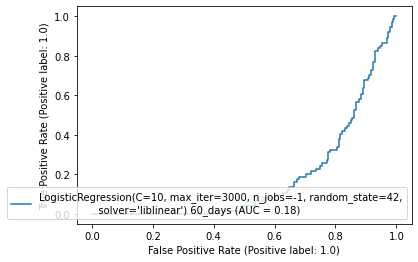

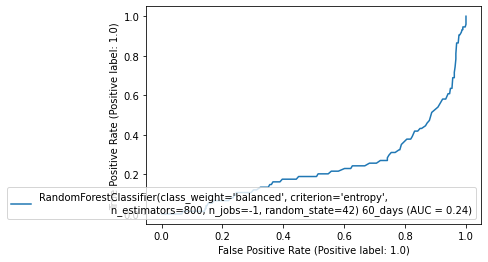

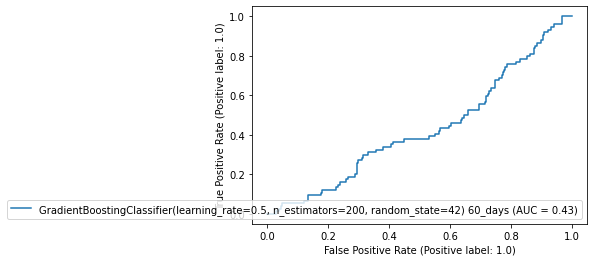

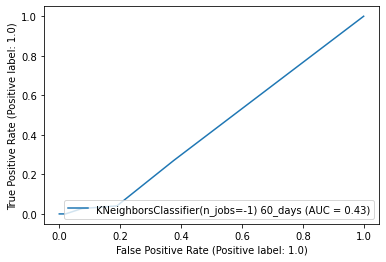

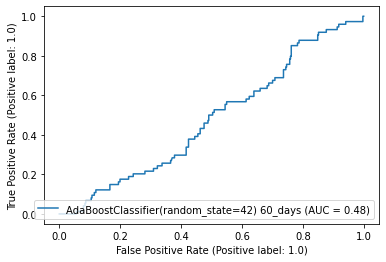

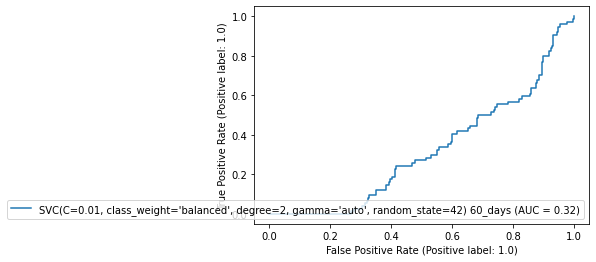

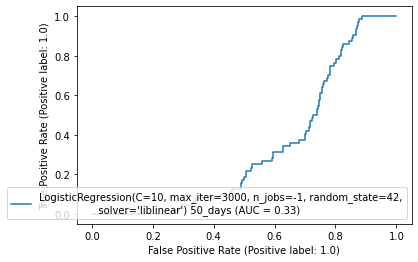

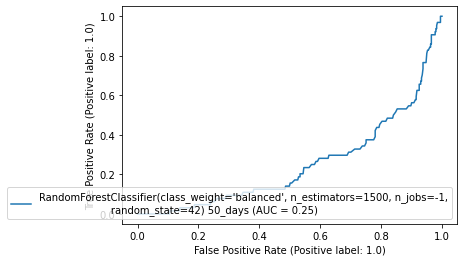

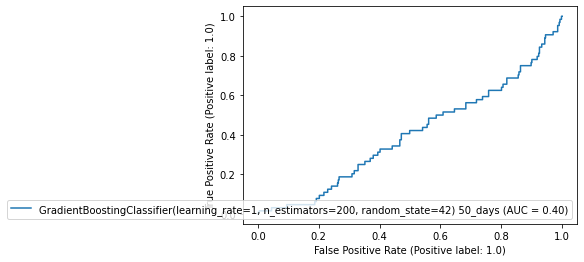

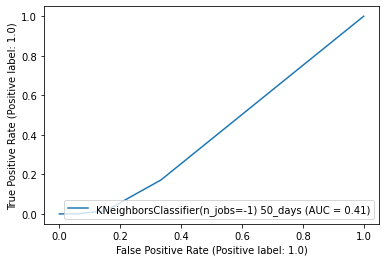

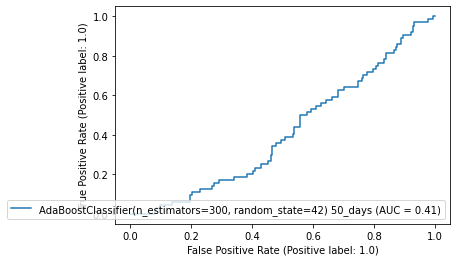

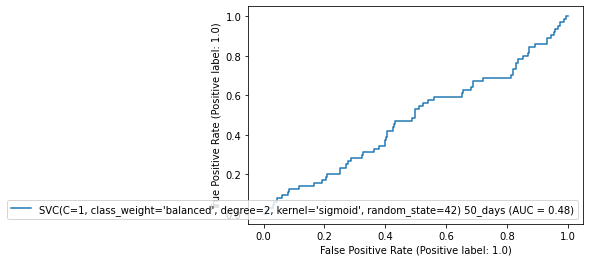

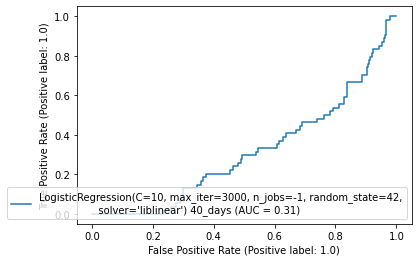

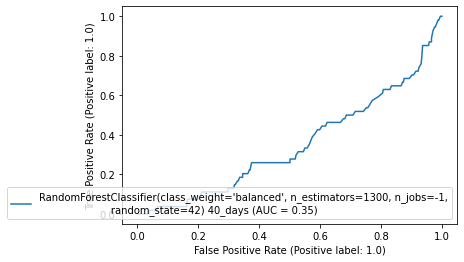

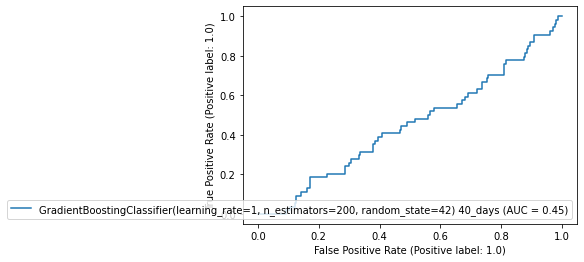

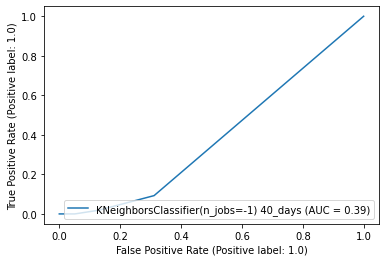

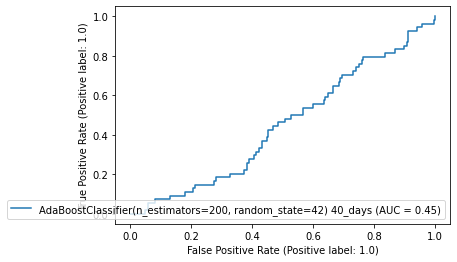

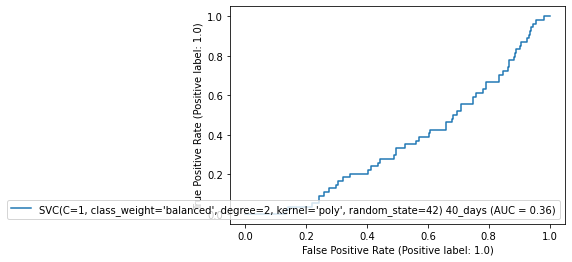

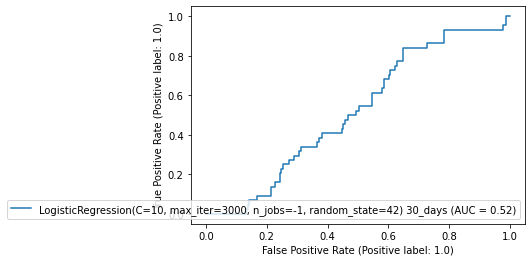

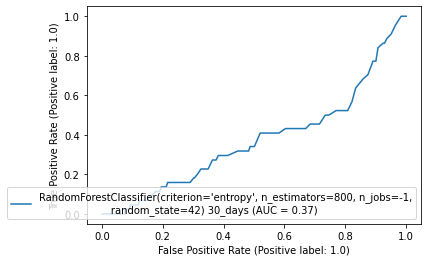

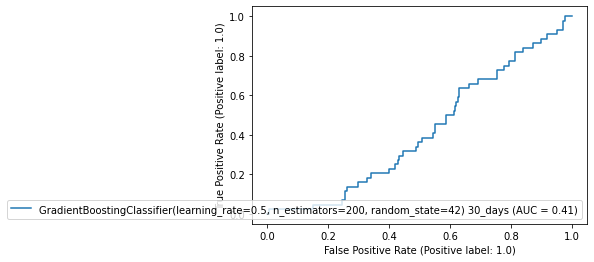

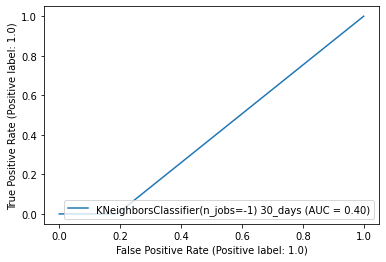

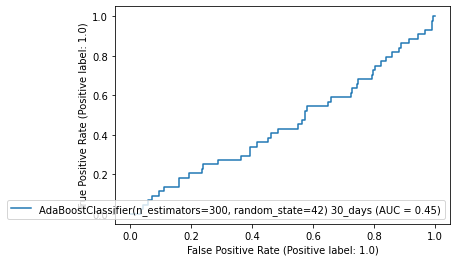

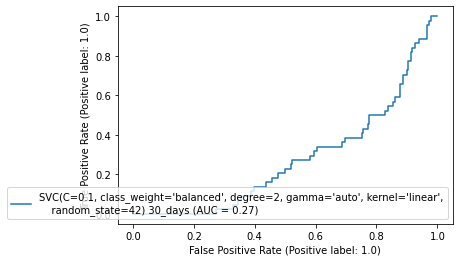

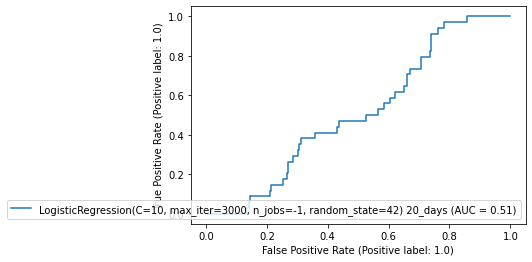

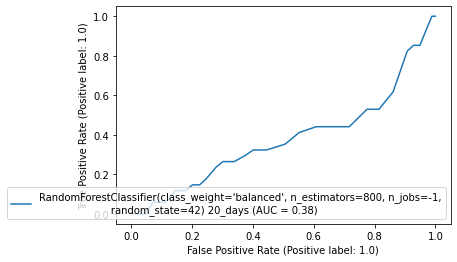

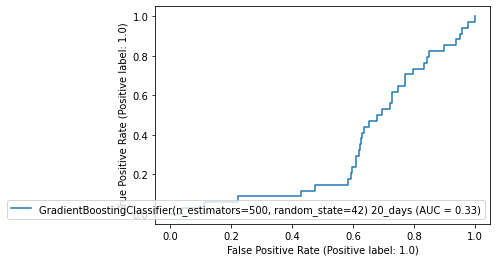

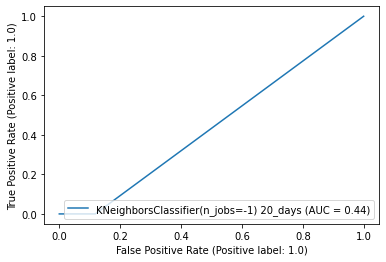

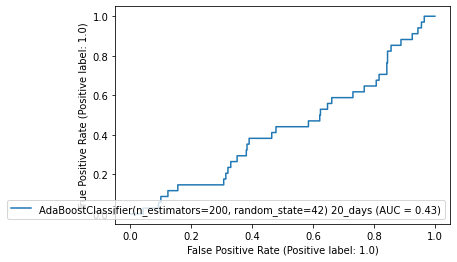

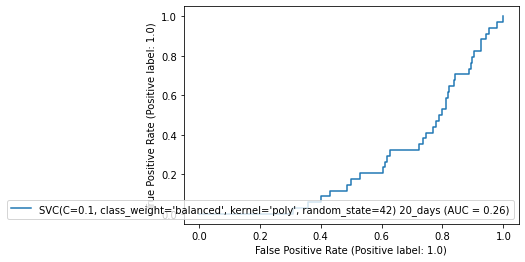

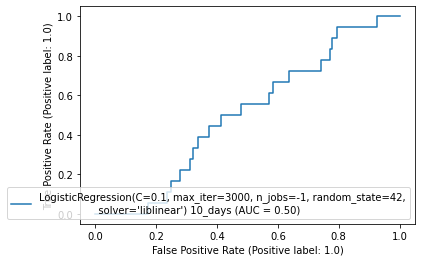

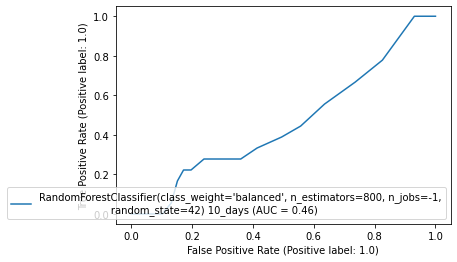

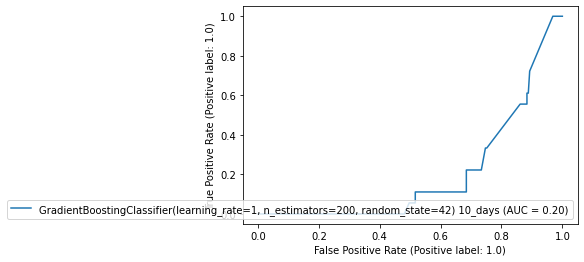

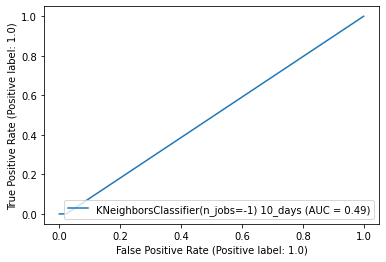

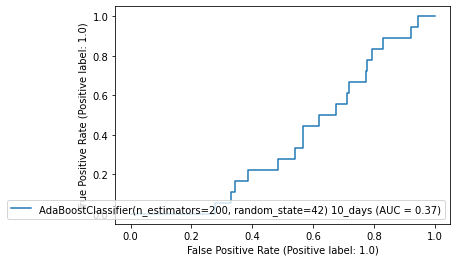

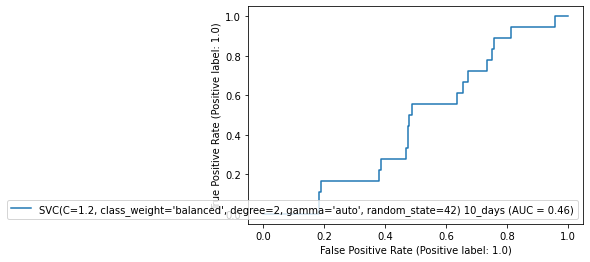

In [26]:
X_train_scale_hyd, X_test_scale_hyd = scale(df_train_hyd, df_test_hyd)
X_train_hyd = df_train_hyd.drop(columns=feat_drop)
X_test_hyd = df_test_hyd.drop(columns=feat_drop)
pred_logreg_hyd = {}
pred_rfc_hyd = {}
pred_gbc_hyd = {}
pred_knn_hyd = {}
pred_abc_hyd = {}
pred_svc_hyd = {}
for label in labels:
    y_train_hyd = df_train_hyd[label]
    y_test_hyd = df_test_hyd[label]
    print(f'Hydraulic {label}')
    clf_logreg_hyd, pred_logreg_hyd[label] = logreg(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd, label)
    clf_rfc_hyd, pred_rfc_hyd[label] = rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd, label)
    clf_gbc_hyd, pred_gbc_hyd[label] = gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd, label)
    clf_knn_hyd, pred_knn_hyd[label] = knn(X_train_scale_hyd, X_test_scale_hyd, y_train_hyd, y_test_hyd, label)
    clf_abc_hyd, pred_abc_hyd[label] = abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd, label)
    clf_svc_hyd, pred_svc_hyd[label] = svc(X_train_scale_hyd, X_test_scale_hyd, y_train_hyd, y_test_hyd, label)

# Transformer

Transformer 60_days


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.97      0.34      0.50       406
         1.0       0.17      0.92      0.28        59

    accuracy                           0.41       465
   macro avg       0.57      0.63      0.39       465
weighted avg       0.86      0.41      0.47       465

[[138 268]
 [  5  54]]

Best Parameters:
 RandomForestClassifier(n_estimators=1400, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.84      0.34      0.49       406
         1.0       0.11      0.56      0.18        59

    accuracy                           0.37       465
   macro avg       0.48      0.45      0.34       465
weighted avg       0.75      0.37      0.45       465

[[139 267]
 [ 26  33]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=500, random_sta

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.98      0.40      0.57       416
         1.0       0.15      0.92      0.26        49

    accuracy                           0.46       465
   macro avg       0.56      0.66      0.42       465
weighted avg       0.89      0.46      0.54       465

[[167 249]
 [  4  45]]

Best Parameters:
 RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.89      0.41      0.56       416
         1.0       0.10      0.57      0.17        49

    accuracy                           0.43       465
   macro avg       0.50      0.49      0.37       465
weighted avg       0.81      0.43      0.52       465

[[171 245]
 [ 21  28]]

Best Parameters:
 GradientBoostingClassifier(n_estimators=500, random_state=42)
   

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.93      0.36      0.52       436
         1.0       0.06      0.62      0.11        29

    accuracy                           0.38       465
   macro avg       0.50      0.49      0.32       465
weighted avg       0.88      0.38      0.49       465

[[157 279]
 [ 11  18]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', n_estimators=1400, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.90       436
         1.0       0.03      0.07      0.04        29

    accuracy                           0.81       465
   macro avg       0.48      0.47      0.47       465
weighted avg       0.88      0.81      0.84       465

[[376  60]
 [ 27   2]]

Best Parameters:
 GradientBoostingClass

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()



Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72       436
         1.0       0.07      0.48      0.12        29

    accuracy                           0.58       465
   macro avg       0.51      0.53      0.42       465
weighted avg       0.89      0.58      0.68       465

[[254 182]
 [ 15  14]]

Best Parameters:
 AdaBoostClassifier(n_estimators=500, random_state=42)
              precision    recall  f1-score   support

         0.0       0.97      0.57      0.72       436
         1.0       0.11      0.76      0.18        29

    accuracy                           0.58       465
   macro avg       0.54      0.66      0.45       465
weighted avg       0.92      0.58      0.69       465

[[249 187]
 [  7  22]]

Best Parameters:
 SVC(C=0.1, class_weight='balanced', degree=2, gamma='auto', kernel='sigmoid',
    random_state=42)
              precision    recall  f1-score

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.97      0.39      0.56       446
         1.0       0.05      0.68      0.09        19

    accuracy                           0.41       465
   macro avg       0.51      0.54      0.32       465
weighted avg       0.93      0.41      0.54       465

[[176 270]
 [  6  13]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       446
         1.0       0.00      0.00      0.00        19

    accuracy                           0.95       465
   macro avg       0.48      0.50      0.49       465
weighted avg       0.92      0.95      0.94       465

[[443   3]
 [ 19   0]]

Best Parameters:
 Gra

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.1, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89       456
         1.0       0.05      0.56      0.10         9

    accuracy                           0.80       465
   macro avg       0.52      0.68      0.49       465
weighted avg       0.97      0.80      0.87       465

[[368  88]
 [  4   5]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=1500, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.98       465
   macro avg       0.49      0.50      0.50       465
weighted avg       0.96      0.98      0.97       465

[[456   0]
 [  9   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.01, n_estimators=700,
                           random_state=42)
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91       456
         1.0       0.09      0.78      0.16         9

    accuracy                           0.84       465
   macro avg       0.54      0.81      0.53       465
weighted avg       0.98      0.84      0.90       465

[[383  73]
 [  2   7]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.96       465
   macro avg       0.49      0.49      0.49       465
weighted avg       0.96      0.96      0.96       465

[[448   8]
 [  9   0]]

Best Parameters:
 AdaBoostClassifier(n_estimators=300, random_state=42)
              precision    recall  f1-score   su

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 SVC(C=0.1, class_weight='balanced', degree=2, random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88       456
         1.0       0.02      0.22      0.04         9

    accuracy                           0.78       465
   macro avg       0.50      0.51      0.46       465
weighted avg       0.96      0.78      0.86       465

[[362  94]
 [  7   2]]


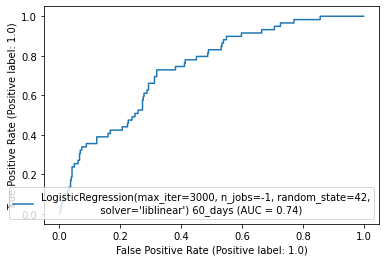

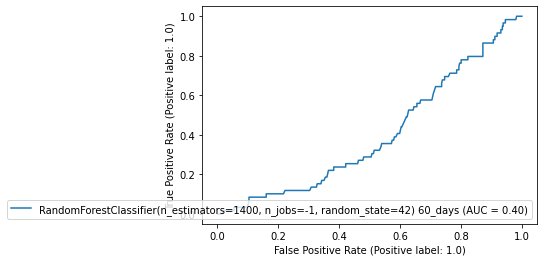

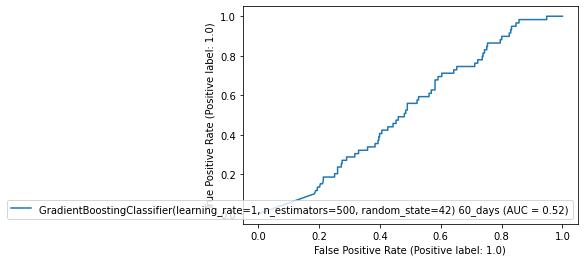

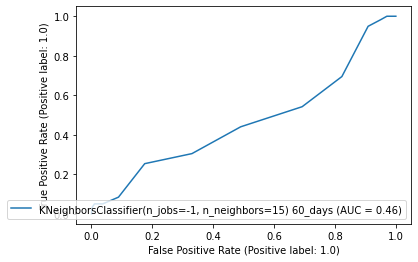

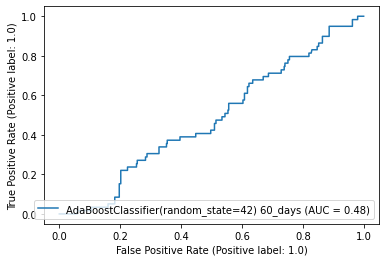

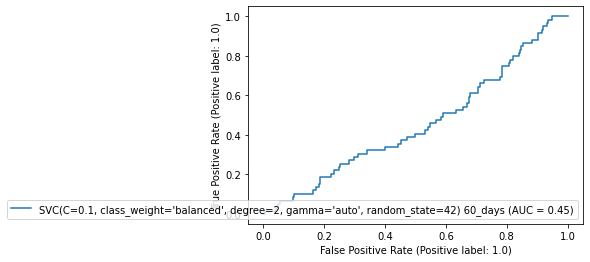

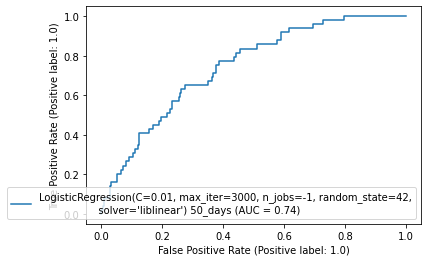

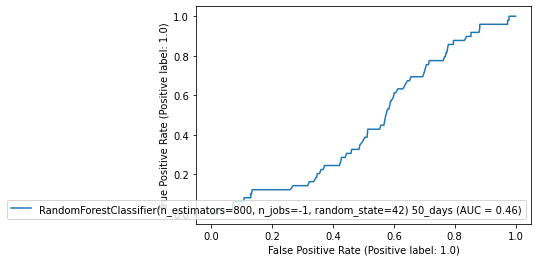

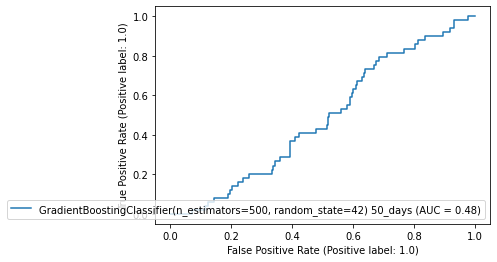

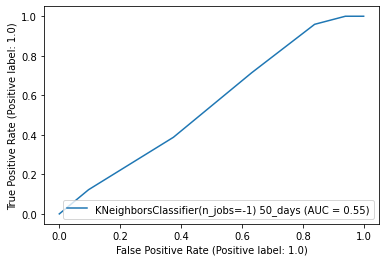

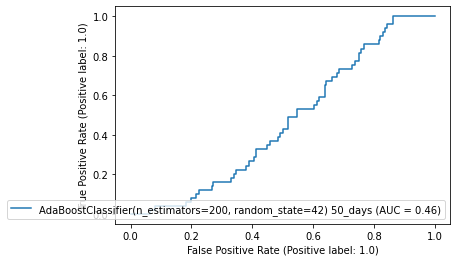

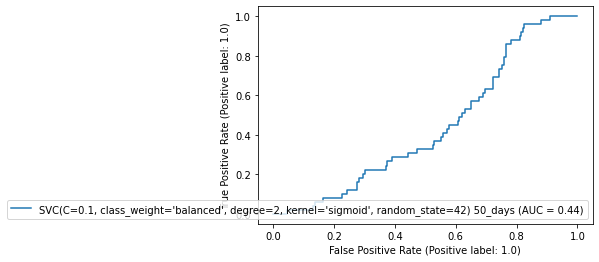

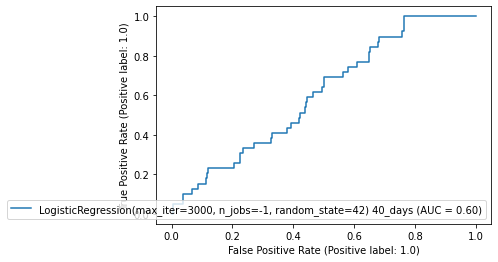

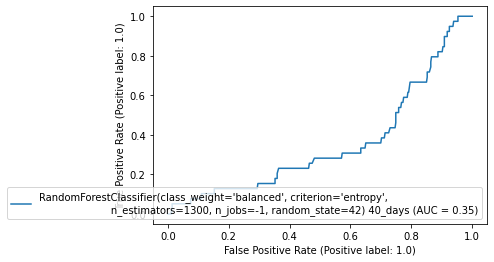

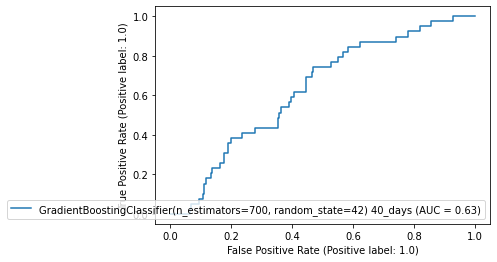

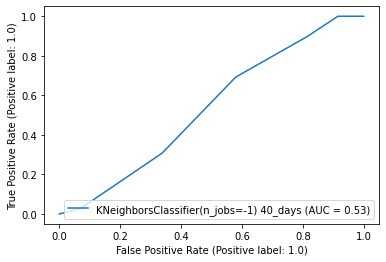

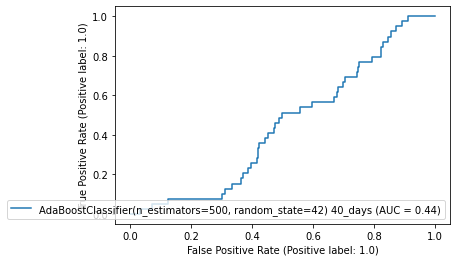

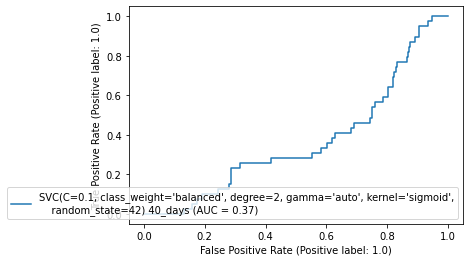

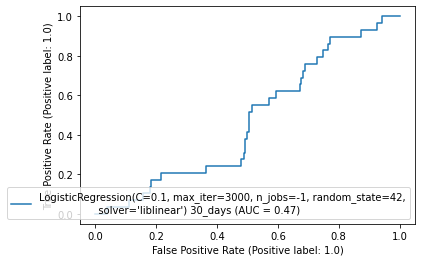

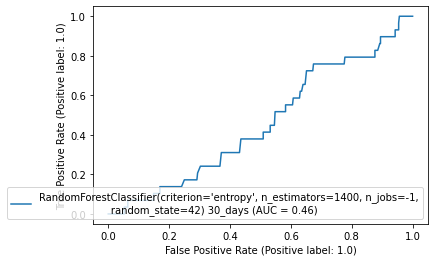

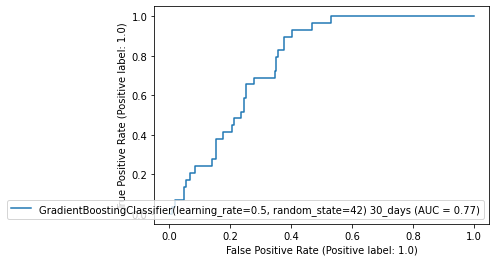

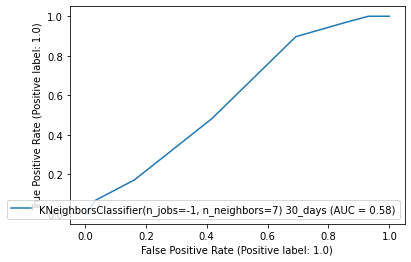

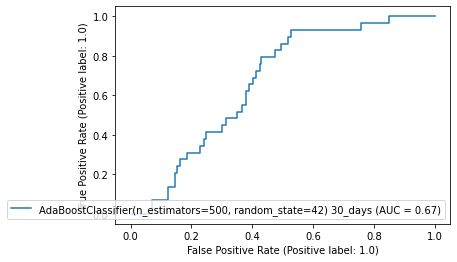

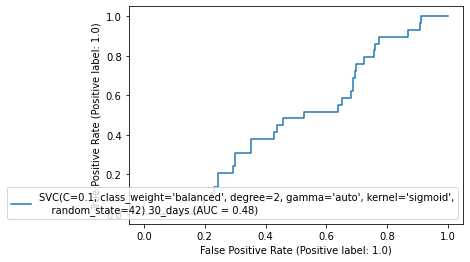

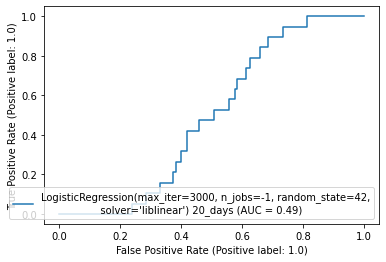

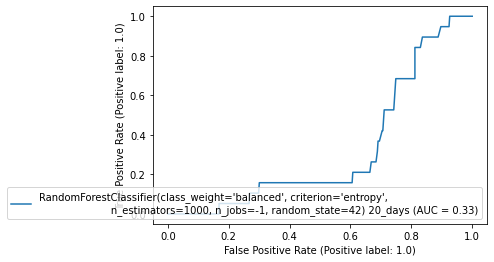

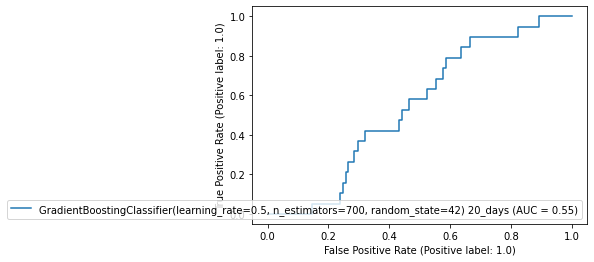

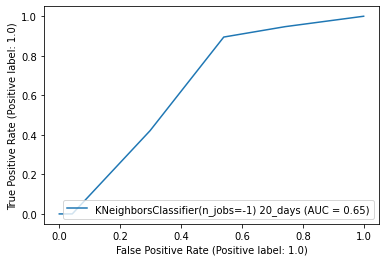

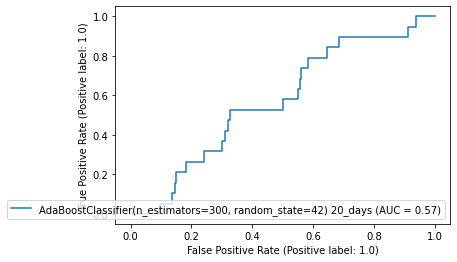

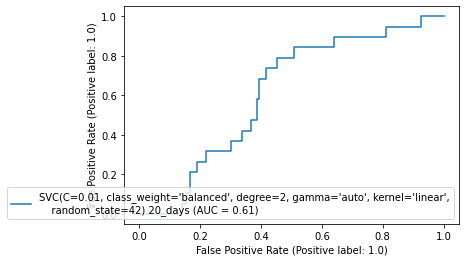

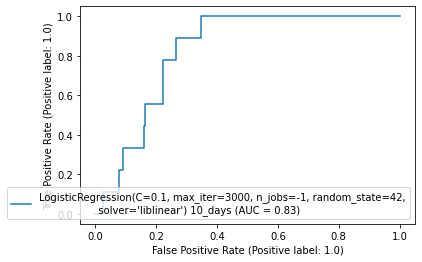

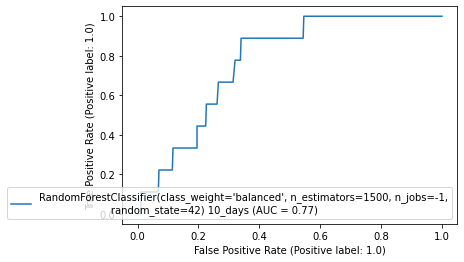

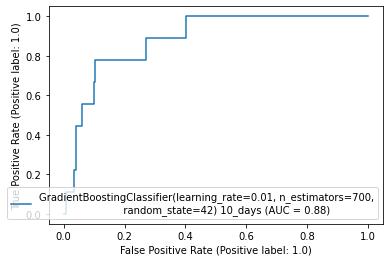

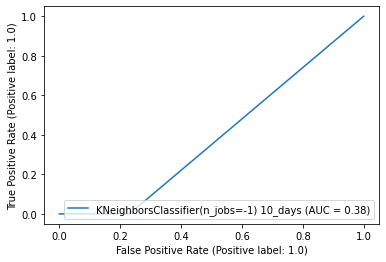

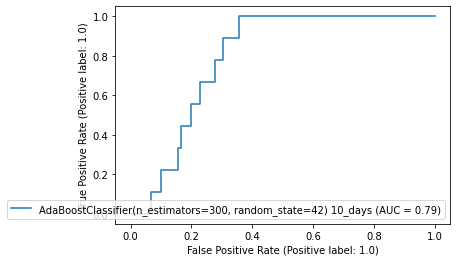

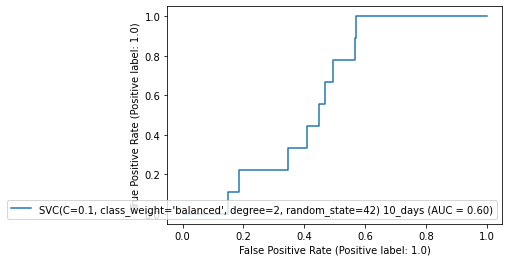

In [27]:
X_train_scale_transf, X_test_scale_transf = scale(df_train_transf, df_test_transf)
X_train_transf = df_train_transf.drop(columns=feat_drop)
X_test_transf = df_test_transf.drop(columns=feat_drop)
pred_logreg_transf = {}
pred_rfc_transf = {}
pred_gbc_transf = {}
pred_knn_transf = {}
pred_abc_transf = {}
pred_svc_transf = {}
for label in labels:
    y_train_transf = df_train_transf[label]
    y_test_transf = df_test_transf[label]
    print(f'Transformer {label}')
    clf_logreg_transf, pred_logreg_transf[label] = logreg(X_train_transf, X_test_transf, y_train_transf, y_test_transf, label)
    clf_rfc_transf, pred_rfc_transf[label] = rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf, label)
    clf_gbc_transf, pred_gbc_transf[label] = gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf, label)
    clf_knn_transf, pred_knn_transf[label] = knn(X_train_scale_transf, X_test_scale_transf, y_train_transf, y_test_transf, label)
    clf_abc_transf, pred_abc_transf[label] = abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf, label)
    clf_svc_transf, pred_svc_transf[label] = svc(X_train_scale_transf, X_test_scale_transf, y_train_transf, y_test_transf, label)

# Generator Bearing

Generator Bearing 60_days

Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       406
         1.0       0.05      0.05      0.05        59

    accuracy                           0.77       465
   macro avg       0.46      0.46      0.46       465
weighted avg       0.76      0.77      0.76       465

[[354  52]
 [ 56   3]]

Best Parameters:
 RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       406
         1.0       0.00      0.00      0.00        59

    accuracy                           0.71       465
   macro avg       0.42      0.41      0.42       465
weighted avg       0.74      0.71      0.72       465

[[330  76]
 [ 59   0]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
              prec

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       426
         1.0       0.06      0.05      0.06        39

    accuracy                           0.86       465
   macro avg       0.49      0.49      0.49       465
weighted avg       0.84      0.86      0.85       465

[[397  29]
 [ 37   2]]

Best Parameters:
 RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       426
         1.0       0.00      0.00      0.00        39

    accuracy                           0.85       465
   macro avg       0.45      0.46      0.46       465
weighted avg       0.83      0.85      0.84       465

[[394  32]
 [ 39   0]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, n_estimators=500, random_s

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.90       465
   macro avg       0.47      0.48      0.47       465
weighted avg       0.88      0.90      0.89       465

[[419  17]
 [ 29   0]]

Best Parameters:
 RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.92       465
   macro avg       0.47      0.49      0.48       465
weighted avg       0.88      0.92      0.90       465

[[426  10]
 [ 29   0]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, random_state=42)
   

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_plot/roc_curve.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()



Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       436
         1.0       0.03      0.07      0.05        29

    accuracy                           0.82       465
   macro avg       0.48      0.47      0.47       465
weighted avg       0.88      0.82      0.85       465

[[379  57]
 [ 27   2]]

Best Parameters:
 AdaBoostClassifier(random_state=42)
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       436
         1.0       0.00      0.00      0.00        29

    accuracy                           0.89       465
   macro avg       0.47      0.48      0.47       465
weighted avg       0.88      0.89      0.88       465

[[415  21]
 [ 29   0]]

Best Parameters:
 SVC(C=1.2, class_weight='balanced', degree=2, gamma='auto', kernel='linear',
    random_state=42)
              precision    recall  f1-score   support

         0.0       0.9

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       446
         1.0       0.00      0.00      0.00        19

    accuracy                           0.94       465
   macro avg       0.48      0.49      0.48       465
weighted avg       0.92      0.94      0.93       465

[[436  10]
 [ 19   0]]

Best Parameters:
 RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       446
         1.0       0.00      0.00      0.00        19

    accuracy                           0.95       465
   macro avg       0.48      0.50      0.49       465
weighted avg       0.92      0.95      0.94       465

[[444   2]
 [ 19   0]]

Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=500, ran

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=0.01, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.97       465
   macro avg       0.49      0.49      0.49       465
weighted avg       0.96      0.97      0.96       465

[[450   6]
 [  9   0]]

Best Parameters:
 RandomForestClassifier(class_weight='balanced', n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.98       465
   macro avg       0.49      0.50      0.50       465
weighted avg       0.96      0.98      0.97       465

[[456   0]
 [  9   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       456
         1.0       0.23      0.33      0.27         9

    accuracy                           0.97       465
   macro avg       0.61      0.66      0.63       465
weighted avg       0.97      0.97      0.97       465

[[446  10]
 [  6   3]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       456
         1.0       0.00      0.00      0.00         9

    accuracy                           0.97       465
   macro avg       0.49      0.50      0.49       465
weighted avg       0.96      0.97      0.97       465

[[452   4]
 [  9   0]]

Best Parameters:
 AdaBoostClassifier(random_state=42)
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.

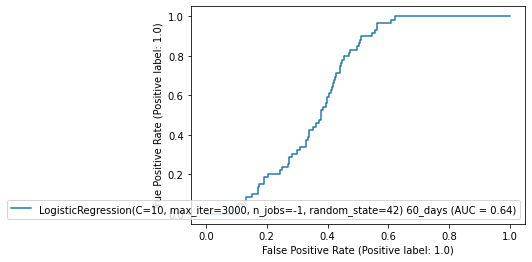

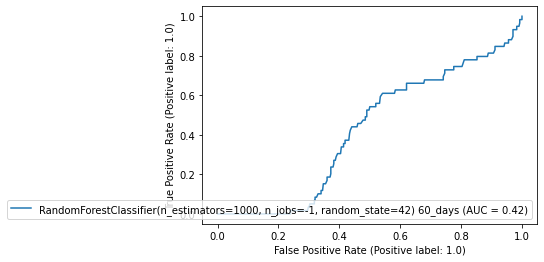

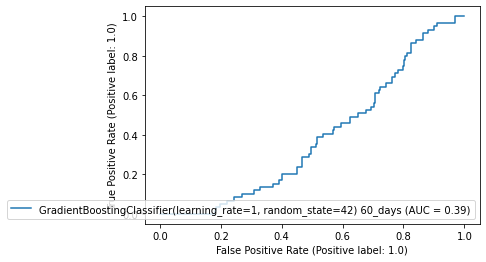

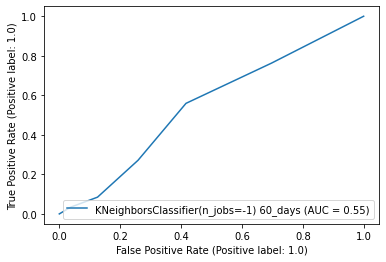

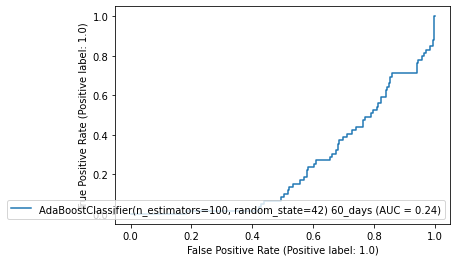

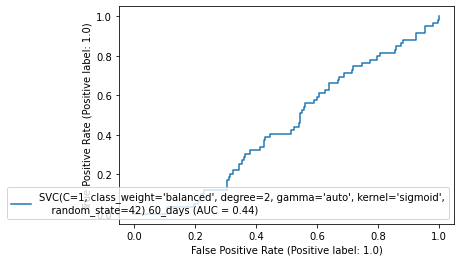

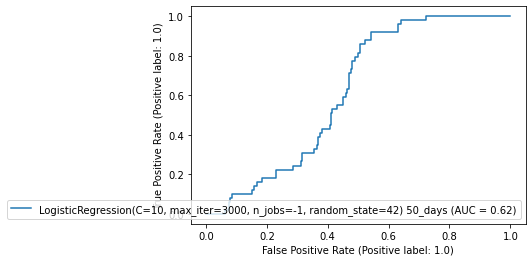

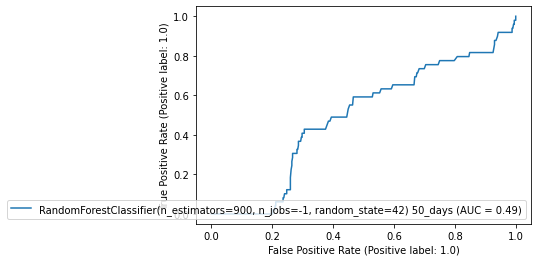

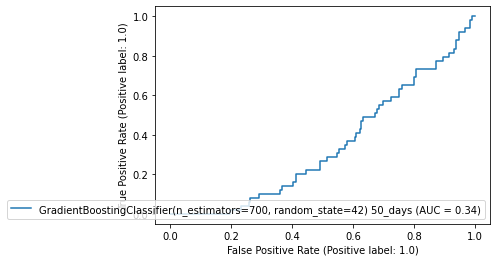

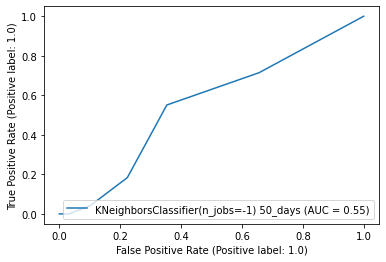

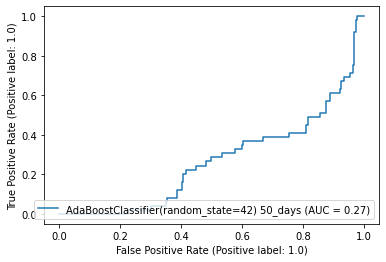

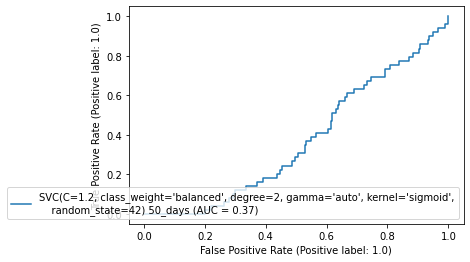

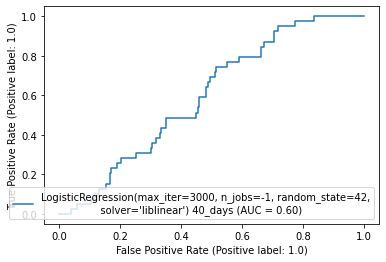

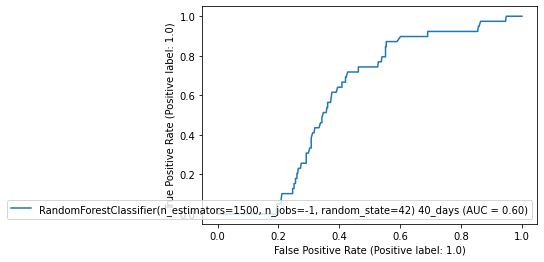

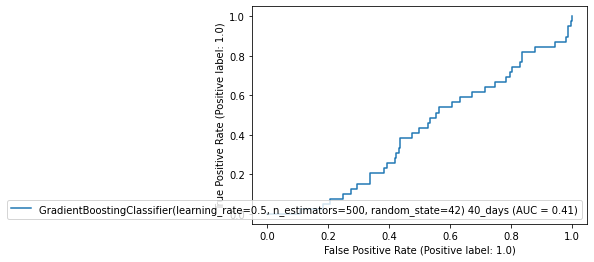

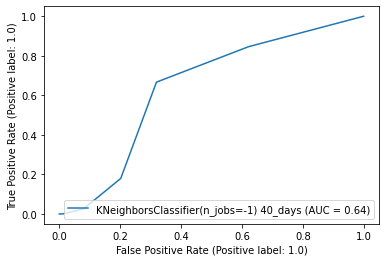

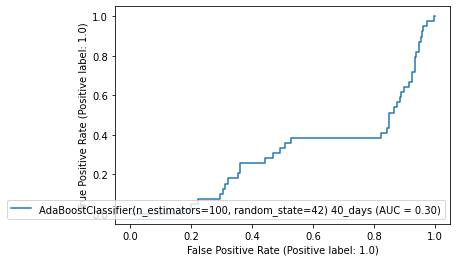

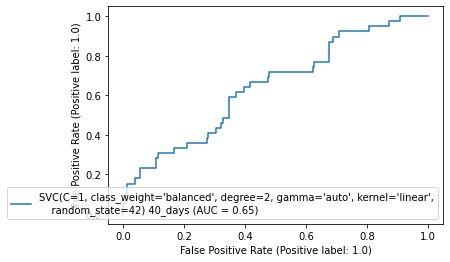

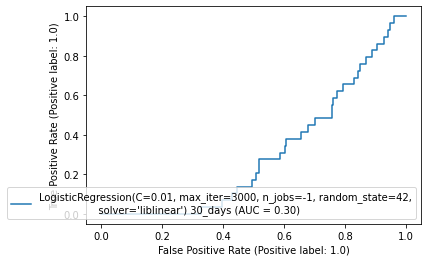

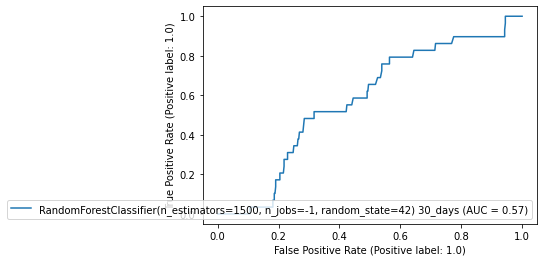

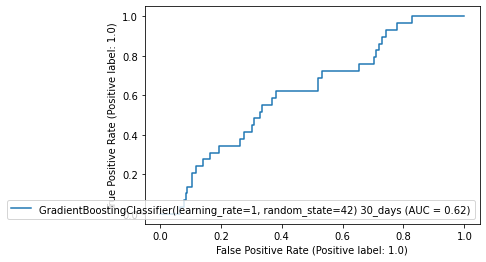

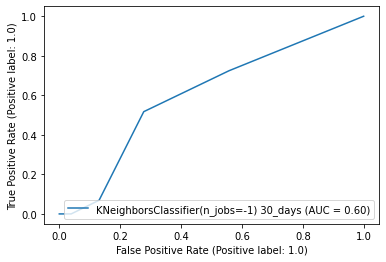

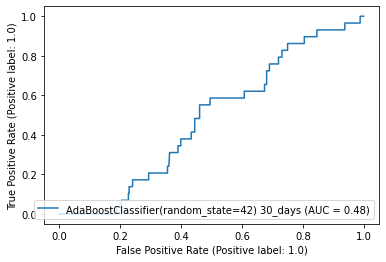

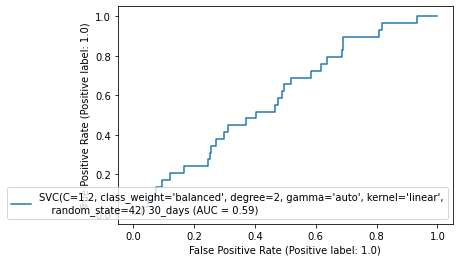

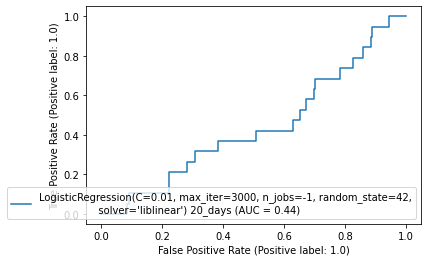

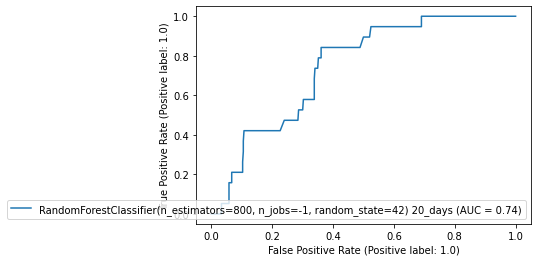

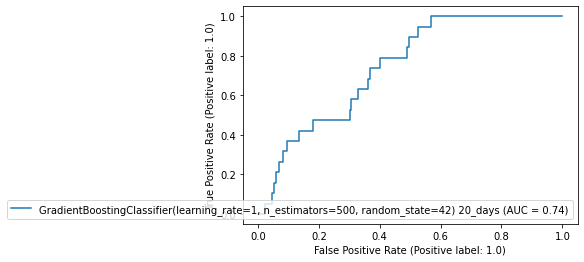

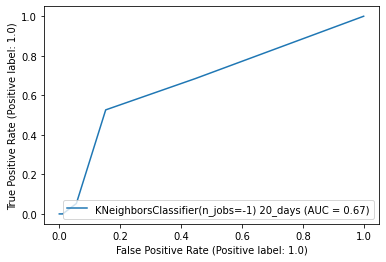

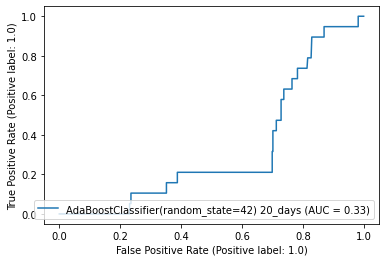

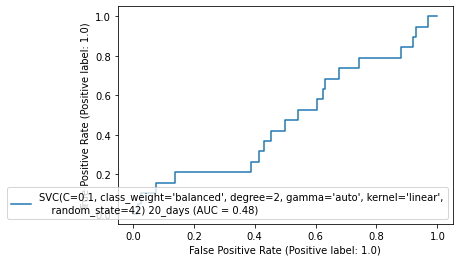

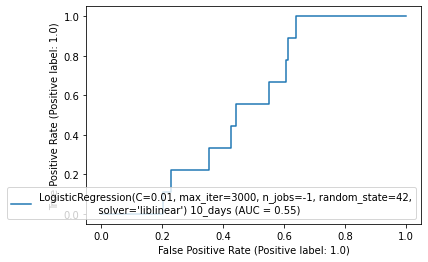

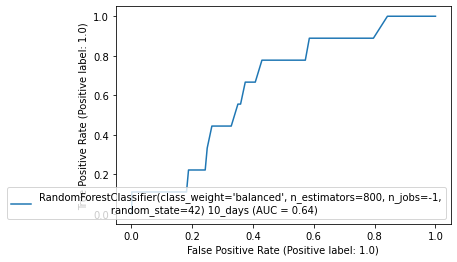

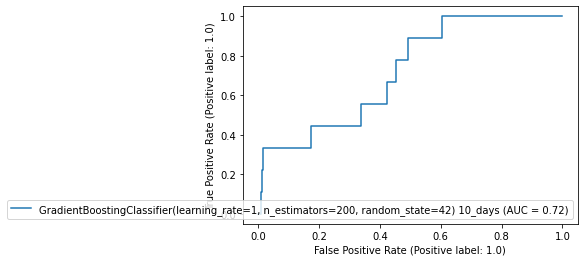

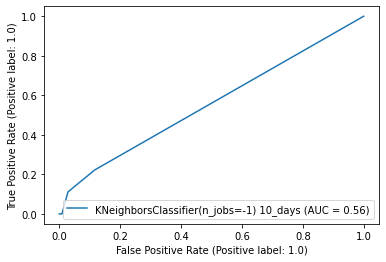

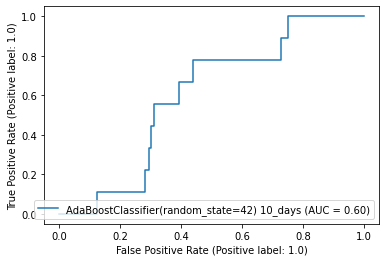

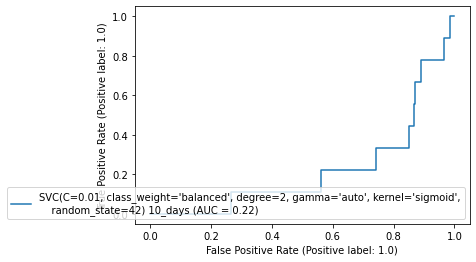

In [28]:
X_train_scale_gen_bear, X_test_scale_gen_bear = scale(df_train_gen_bear, df_test_gen_bear)
X_train_gen_bear = df_train_gen_bear.drop(columns=feat_drop)
X_test_gen_bear = df_test_gen_bear.drop(columns=feat_drop)
pred_logreg_gen_bear = {}
pred_rfc_gen_bear = {}
pred_gbc_gen_bear = {}
pred_knn_gen_bear = {}
pred_abc_gen_bear = {}
pred_svc_gen_bear = {}
for label in labels:
    y_train_gen_bear = df_train_gen_bear[label]
    y_test_gen_bear = df_test_gen_bear[label]
    print(f'Generator Bearing {label}')
    clf_logreg_gen_bear, pred_logreg_gen_bear[label] = logreg(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear, label)
    clf_rfc_gen_bear, pred_rfc_gen_bear[label] = rfc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear, label)
    clf_gbc_gen_bear, pred_gbc_gen_bear[label] = gbc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear, label)
    clf_knn_gen_bear, pred_knn_gen_bear[label] = knn(X_train_scale_gen_bear, X_test_scale_gen_bear, y_train_gen_bear, y_test_gen_bear, label)
    clf_abc_gen_bear, pred_abc_gen_bear[label] = abc(X_train_gen_bear, X_test_gen_bear, y_train_gen_bear, y_test_gen_bear, label)
    clf_svc_gen_bear, pred_svc_gen_bear[label] = svc(X_train_scale_gen_bear, X_test_scale_gen_bear, y_train_gen_bear, y_test_gen_bear, label)

# THRESHOLDS TO REDUCE FP 

In [29]:
# We could reduce the number of FP by studying the best threshold for each componenent. 
#Due to lack of time, that will be for another time

<AxesSubplot:xlabel='10_days', ylabel='y_score'>

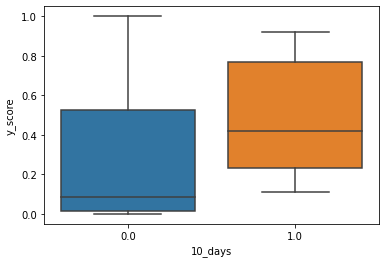

In [58]:
sns.boxplot(x=y_test_gen, y=pred_logreg_gen['40_days']['y_score'])

<AxesSubplot:xlabel='10_days', ylabel='y_score'>

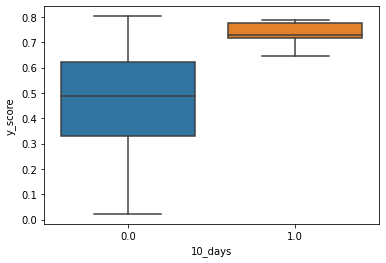

In [64]:
sns.boxplot(x=y_test_gen, y = pred_rfc_gen['60_days']['y_score'])
# pred_gbc_gen 
# pred_knn_gen 
# pred_abc_gen 
# pred_svc_gen 

In [ ]:
# pred_logreg_hyd 
# pred_rfc_hyd
# pred_gbc_hyd
# pred_knn_hyd 
# pred_abc_hyd 
# pred_svc_hyd

In [ ]:
# pred_logreg_transf
# pred_rfc_transf 
# pred_gbc_transf 
# pred_knn_transf 
# pred_abc_transf 
# pred_svc_transf 

In [ ]:
# pred_logreg_gen_bear 
# pred_rfc_gen_bear
# pred_gbc_gen_bear 
# pred_knn_gen_bear 
# pred_abc_gen_bear 
# pred_svc_gen_bear 

### Continue in final_automation.ipynb